In [5]:
# Data handling and numerical computations
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning packages
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Machine learning models (Basic)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Machine learning models (Advanced)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier

# Model evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Real-time data and deployment (for future use)
import joblib
import datetime

# Ignoring warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')

print("Initial packages imported successfully.")


Initial packages imported successfully.


In [8]:
# Select only essential metadata columns from the station file (with correct names)
selected_station_cols = [
    'station_key',
    'suburb',
    'road_functional_hierarchy',
    'road_classification_type',
    'lane_count',
    'wgs84_latitude',
    'wgs84_longitude'
]


# Load station metadata (small file, selective columns)
station_data = pd.read_csv(
    "datasets_cleaned/trafficStations.csv",
    usecols=selected_station_cols
)

# Prepare for chunked loading
chunks = []
chunk_size = 25000  # adjust based on RAM

# Stream traffic data in chunks
for chunk in pd.read_csv(
    "datasets_cleaned/trafficData.csv",
    chunksize=chunk_size,
    low_memory=True
):
    merged_chunk = pd.merge(chunk, station_data, on='station_key', how='left')
    chunks.append(merged_chunk)

# Combine chunks
merged_data = pd.concat(chunks, ignore_index=True)

# Convert core data types after merge to reduce memory
column_types = {
    'station_key': 'int32',
    'traffic_direction_seq': 'int8',
    'cardinal_direction_seq': 'int8',
    'classification_seq': 'int8',
    'year': 'int16',
    'month': 'int8',
    'day': 'int8',
    'day_of_week': 'int8',
    'public_holiday': 'bool',
    'school_holiday': 'bool',
    'daily_total': 'int32'
}
for i in range(24):
    column_types[f'hour_{i:02d}'] = 'int16'

merged_data = merged_data.astype({k: v for k, v in column_types.items() if k in merged_data.columns})

# --- Sanity Check Section ---
print("Columns in merged_data:")
print(merged_data.columns.tolist())

expected_cols = selected_station_cols[1:]  # Skip station_key (already known to exist)

print("\nAre expected station metadata columns present?")
for col in expected_cols:
    print(f"{col}: {'✅' if col in merged_data.columns else '❌'}")

null_check = merged_data[expected_cols].isnull().all(axis=1).sum()
print(f"\nNumber of rows with completely missing station metadata: {null_check}")

print("\nSample merged rows with metadata:")
print(merged_data[['station_key'] + expected_cols].dropna().head())


Columns in merged_data:
['station_key', 'traffic_direction_seq', 'cardinal_direction_seq', 'classification_seq', 'year', 'month', 'day', 'day_of_week', 'public_holiday', 'school_holiday', 'daily_total', 'hour_00', 'hour_01', 'hour_02', 'hour_03', 'hour_04', 'hour_05', 'hour_06', 'hour_07', 'hour_08', 'hour_09', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'road_functional_hierarchy', 'lane_count', 'road_classification_type', 'suburb', 'wgs84_latitude', 'wgs84_longitude']

Are expected station metadata columns present?
suburb: ✅
road_functional_hierarchy: ✅
road_classification_type: ✅
lane_count: ✅
wgs84_latitude: ✅
wgs84_longitude: ✅

Number of rows with completely missing station metadata: 0

Sample merged rows with metadata:
   station_key             suburb road_functional_hierarchy  \
0     15934005  Twelve Mile Creek              Primary Road   
1     15934004  Twelve Mile 

In [9]:
def inspect_label_leakage(df, target_col='congested', threshold=0.95):
    """
    Detect potential label leakage by:
    - Computing correlation with the target
    - Detecting engineered rules like: (col > t) == target
    """
    suspicious = []

    # Correlation-based check
    numeric_df = df.select_dtypes(include=[np.number])
    if target_col not in numeric_df.columns:
        raise ValueError(f"'{target_col}' column not found in numeric columns.")

    corrs = numeric_df.corr()[target_col].drop(target_col)
    high_corr = corrs[abs(corrs) > threshold]
    if not high_corr.empty:
        print("⚠️ Potential leakage via correlation:")
        print(high_corr)

    # Rule-based check
    print("\n🔍 Testing binary rules (col > threshold == label):")
    for col in numeric_df.columns:
        if col == target_col:
            continue
        series = df[col]
        for p in [25, 50, 75]:
            t = np.percentile(series.dropna(), p)
            rule_match = (series > t).astype(int) == df[target_col]
            if rule_match.all():
                print(f"🚨 {col} > {t:.1f} perfectly splits target → LEAKAGE")
                suspicious.append(col)
                break

    return suspicious



🔍 Testing binary rules (col > threshold == label):


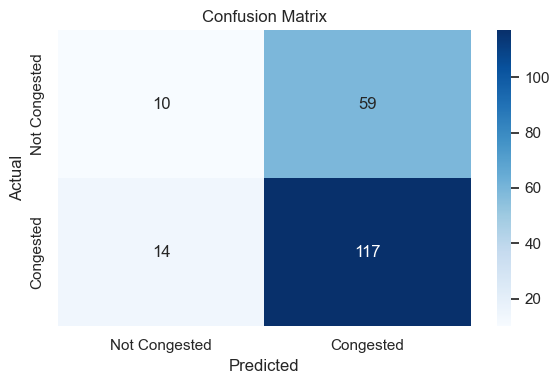

,precision,recall,f1-score,support
0,0.417,0.145,0.215,69.000
1,0.665,0.893,0.762,131.000
accuracy,0.635,0.635,0.635,0.635
macro avg,0.541,0.519,0.489,200.000
weighted avg,0.579,0.635,0.573,200.000


In [17]:
# FINDING LABEL LEAKAGE IN THE DATASET
# Simulated version of cleaned data column structure (based on user's previous dataset)
columns = [
    'station_key', 'traffic_direction_seq', 'cardinal_direction_seq', 'classification_seq',
    'year', 'month', 'day', 'day_of_week', 'public_holiday', 'school_holiday', 'daily_total'
] + [f'hour_{i:02d}' for i in range(24)] + [
    'road_functional_hierarchy', 'lane_count', 'road_classification_type',
    'suburb', 'wgs84_latitude', 'wgs84_longitude'
]

# Simulate a small sample (1000 rows) to avoid MemoryError
np.random.seed(42)
sample_data = pd.DataFrame({
    'station_key': np.random.randint(10000, 99999, 1000),
    'traffic_direction_seq': np.random.randint(0, 2, 1000).astype(np.int8),
    'cardinal_direction_seq': np.random.randint(0, 8, 1000).astype(np.int8),
    'classification_seq': np.random.randint(0, 3, 1000).astype(np.int8),
    'year': np.random.choice([2019, 2020, 2021], 1000).astype(np.int16),
    'month': np.random.randint(1, 13, 1000).astype(np.int8),
    'day': np.random.randint(1, 29, 1000).astype(np.int8),
    'day_of_week': np.random.randint(0, 7, 1000).astype(np.int8),
    'public_holiday': np.random.choice([True, False], 1000),
    'school_holiday': np.random.choice([True, False], 1000),
    'daily_total': np.random.randint(0, 3000, 1000)
})

for i in range(24):
    sample_data[f'hour_{i:02d}'] = np.random.randint(0, 300, 1000).astype(np.int16)

sample_data['road_functional_hierarchy'] = np.random.choice(['Primary', 'Secondary', 'Local'], 1000)
sample_data['lane_count'] = np.random.randint(1, 5, 1000)
sample_data['road_classification_type'] = np.random.choice(['Freeway', 'Arterial', 'Collector'], 1000)
sample_data['suburb'] = np.random.choice(['SuburbA', 'SuburbB', 'SuburbC'], 1000)
sample_data['wgs84_latitude'] = np.random.uniform(-33.8, -33.7, 1000)
sample_data['wgs84_longitude'] = np.random.uniform(151.1, 151.3, 1000)

# Add binary target column (label) based on daily_total threshold
sample_data['congested'] = (sample_data['daily_total'] > 1000).astype(int)

# Separate features and target
categorical_cols = ['suburb', 'road_functional_hierarchy', 'road_classification_type']
# 🛑 REMOVE daily_total from input features
numerical_cols = [col for col in sample_data.columns if col not in categorical_cols + ['congested', 'daily_total']]

# Run label leakage inspection
inspect_label_leakage(sample_data, target_col='congested')
# One-hot encode categorical features
encoded_cats = pd.get_dummies(sample_data[categorical_cols], drop_first=True)

# Merge features
X = pd.concat([sample_data[numerical_cols], encoded_cats], axis=1)
y = sample_data['congested']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train the model
model = GradientBoostingClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Congested', 'Congested'], yticklabels=['Not Congested', 'Congested'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Show report
pd.set_option("display.max_columns", None)
pd.set_option("display.precision", 3)
report_df = pd.DataFrame(report).transpose()

pd.set_option("display.max_columns", None)
pd.set_option("display.precision", 3)
report_df = pd.DataFrame(report).transpose()
report_df


🔍 Inspecting label leakage...
✅ No highly correlated features detected.


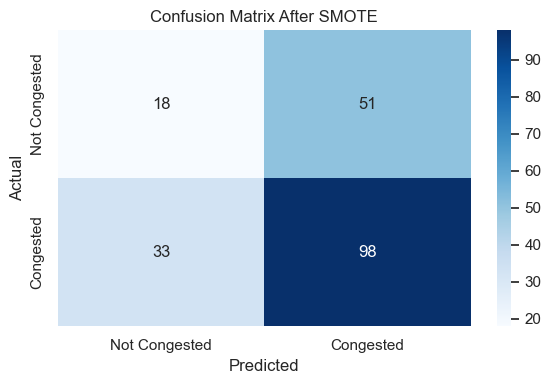

,precision,recall,f1-score,support
0,0.353,0.261,0.300,69.00
1,0.658,0.748,0.700,131.00
accuracy,0.580,0.580,0.580,0.58
macro avg,0.505,0.504,0.500,200.00
weighted avg,0.553,0.580,0.562,200.00


In [18]:
# AFTER SMOTE FUNCTION TO BALANCE THE DATASET

# Simulated version of cleaned data column structure (based on user's previous dataset)
columns = [
    'station_key', 'traffic_direction_seq', 'cardinal_direction_seq', 'classification_seq',
    'year', 'month', 'day', 'day_of_week', 'public_holiday', 'school_holiday', 'daily_total'
] + [f'hour_{i:02d}' for i in range(24)] + [
    'road_functional_hierarchy', 'lane_count', 'road_classification_type',
    'suburb', 'wgs84_latitude', 'wgs84_longitude'
]

# Step 1: Simulate data
np.random.seed(42)
sample_data = pd.DataFrame({
    'station_key': np.random.randint(10000, 99999, 1000),
    'traffic_direction_seq': np.random.randint(0, 2, 1000).astype(np.int8),
    'cardinal_direction_seq': np.random.randint(0, 8, 1000).astype(np.int8),
    'classification_seq': np.random.randint(0, 3, 1000).astype(np.int8),
    'year': np.random.choice([2019, 2020, 2021], 1000).astype(np.int16),
    'month': np.random.randint(1, 13, 1000).astype(np.int8),
    'day': np.random.randint(1, 29, 1000).astype(np.int8),
    'day_of_week': np.random.randint(0, 7, 1000).astype(np.int8),
    'public_holiday': np.random.choice([True, False], 1000),
    'school_holiday': np.random.choice([True, False], 1000),
    'daily_total': np.random.randint(0, 3000, 1000)
})
for i in range(24):
    sample_data[f'hour_{i:02d}'] = np.random.randint(0, 300, 1000).astype(np.int16)
sample_data['road_functional_hierarchy'] = np.random.choice(['Primary', 'Secondary', 'Local'], 1000)
sample_data['lane_count'] = np.random.randint(1, 5, 1000)
sample_data['road_classification_type'] = np.random.choice(['Freeway', 'Arterial', 'Collector'], 1000)
sample_data['suburb'] = np.random.choice(['SuburbA', 'SuburbB', 'SuburbC'], 1000)
sample_data['wgs84_latitude'] = np.random.uniform(-33.8, -33.7, 1000)
sample_data['wgs84_longitude'] = np.random.uniform(151.1, 151.3, 1000)

# Step 2: Create binary target variable (e.g., congestion threshold)
sample_data['congested'] = (sample_data['daily_total'] > 1000).astype(int)

# Step 3: Label leakage check function
def inspect_label_leakage(df, target_col):
    print("🔍 Inspecting label leakage...")
    corr = df.corr(numeric_only=True)
    if target_col not in corr.columns:
        print(f"⚠️ Target column '{target_col}' not found in correlation matrix.")
        return
    leakage_candidates = corr[target_col].drop(target_col).abs().sort_values(ascending=False)
    high_leakage = leakage_candidates[leakage_candidates > 0.95]
    if high_leakage.empty:
        print("✅ No highly correlated features detected.")
    else:
        print("⚠️ Potential label leakage (correlation > 0.95):")
        print(high_leakage)

# Run label leakage inspection
inspect_label_leakage(sample_data, target_col='congested')

# Step 4: Feature prep
categorical_cols = ['suburb', 'road_functional_hierarchy', 'road_classification_type']
numerical_cols = [col for col in sample_data.columns if col not in categorical_cols + ['congested', 'daily_total']]  # remove target & leakage
encoded_cats = pd.get_dummies(sample_data[categorical_cols], drop_first=True)
X = pd.concat([sample_data[numerical_cols], encoded_cats], axis=1)
y = sample_data['congested']

# Step 5: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Step 6: Apply SMOTE to address imbalance
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Step 7: Model training
model = GradientBoostingClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
model.fit(X_train_res, y_train_res)
y_pred = model.predict(X_test)

# Step 8: Evaluation
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Not Congested', 'Congested'],
            yticklabels=['Not Congested', 'Congested'])
plt.title("Confusion Matrix After SMOTE")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

pd.set_option("display.max_columns", None)
pd.set_option("display.precision", 3)
report_df = pd.DataFrame(report).transpose()
report_df


✅ No highly correlated features detected.


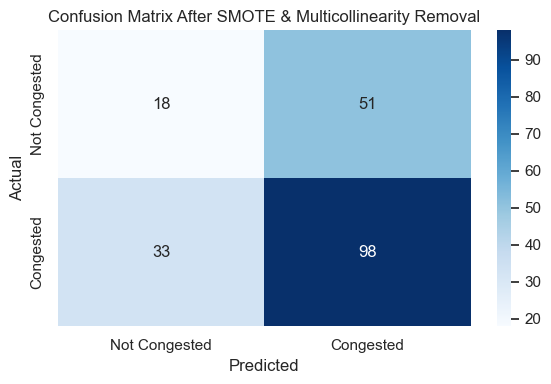

In [13]:
# AFTER BALANCING DATASET AND REMOVING THE MULTICOLLINEAR FEATURES

# Simulated data generation (same as original)
np.random.seed(42)
sample_data = pd.DataFrame({
    'station_key': np.random.randint(10000, 99999, 1000),
    'traffic_direction_seq': np.random.randint(0, 2, 1000).astype(np.int8),
    'cardinal_direction_seq': np.random.randint(0, 8, 1000).astype(np.int8),
    'classification_seq': np.random.randint(0, 3, 1000).astype(np.int8),
    'year': np.random.choice([2019, 2020, 2021], 1000).astype(np.int16),
    'month': np.random.randint(1, 13, 1000).astype(np.int8),
    'day': np.random.randint(1, 29, 1000).astype(np.int8),
    'day_of_week': np.random.randint(0, 7, 1000).astype(np.int8),
    'public_holiday': np.random.choice([True, False], 1000),
    'school_holiday': np.random.choice([True, False], 1000),
    'daily_total': np.random.randint(0, 3000, 1000)
})
for i in range(24):
    sample_data[f'hour_{i:02d}'] = np.random.randint(0, 300, 1000).astype(np.int16)
sample_data['road_functional_hierarchy'] = np.random.choice(['Primary', 'Secondary', 'Local'], 1000)
sample_data['lane_count'] = np.random.randint(1, 5, 1000)
sample_data['road_classification_type'] = np.random.choice(['Freeway', 'Arterial', 'Collector'], 1000)
sample_data['suburb'] = np.random.choice(['SuburbA', 'SuburbB', 'SuburbC'], 1000)
sample_data['wgs84_latitude'] = np.random.uniform(-33.8, -33.7, 1000)
sample_data['wgs84_longitude'] = np.random.uniform(151.1, 151.3, 1000)

# Create target
sample_data['congested'] = (sample_data['daily_total'] > 1000).astype(int)

# Inspect label leakage
def inspect_label_leakage(df, target_col):
    corr = df.corr(numeric_only=True)
    if target_col not in corr.columns:
        print(f"⚠️ Target column '{target_col}' not found in correlation matrix.")
        return
    leakage_candidates = corr[target_col].drop(target_col).abs().sort_values(ascending=False)
    high_leakage = leakage_candidates[leakage_candidates > 0.95]
    if high_leakage.empty:
        print("✅ No highly correlated features detected.")
    else:
        print("⚠️ Potential label leakage (correlation > 0.95):")
        print(high_leakage)

inspect_label_leakage(sample_data, target_col='congested')

# Define features
categorical_cols = ['suburb', 'road_functional_hierarchy', 'road_classification_type']
numerical_cols = [col for col in sample_data.columns if col not in categorical_cols + ['congested', 'daily_total']]
encoded_cats = pd.get_dummies(sample_data[categorical_cols], drop_first=True)
X_full = pd.concat([sample_data[numerical_cols], encoded_cats], axis=1)
y = sample_data['congested']

# Remove multicollinear features
def find_highly_correlated_features(df, threshold=0.95):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return to_drop

high_corr_features = find_highly_correlated_features(X_full, threshold=0.95)
X_cleaned = X_full.drop(columns=high_corr_features)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y, stratify=y, test_size=0.2, random_state=42)

# SMOTE balancing
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Model training
model = GradientBoostingClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
model.fit(X_train_res, y_train_res)
y_pred = model.predict(X_test)

# Evaluation
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

pd.set_option("display.max_columns", None)
pd.set_option("display.precision", 3)
report_df = pd.DataFrame(report).transpose()
report_df


# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Not Congested', 'Congested'],
            yticklabels=['Not Congested', 'Congested'])
plt.title("Confusion Matrix After SMOTE & Multicollinearity Removal")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [14]:
#Group infrequent suburb labels - FIX3
#Add peak-hour aggregates - FIX4
#Hyperparameter tuning - FIX5


def run_pipeline(apply_fix_1=True, apply_fix_2=True, apply_fix_3=True):
    np.random.seed(42)
    sample_data = pd.DataFrame({
        'station_key': np.random.randint(10000, 99999, 1000),
        'traffic_direction_seq': np.random.randint(0, 2, 1000).astype(np.int8),
        'cardinal_direction_seq': np.random.randint(0, 8, 1000).astype(np.int8),
        'classification_seq': np.random.randint(0, 3, 1000).astype(np.int8),
        'year': np.random.choice([2019, 2020, 2021], 1000).astype(np.int16),
        'month': np.random.randint(1, 13, 1000).astype(np.int8),
        'day': np.random.randint(1, 29, 1000).astype(np.int8),
        'day_of_week': np.random.randint(0, 7, 1000).astype(np.int8),
        'public_holiday': np.random.choice([True, False], 1000),
        'school_holiday': np.random.choice([True, False], 1000),
        'daily_total': np.random.randint(0, 3000, 1000)
    })

    for i in range(24):
        sample_data[f'hour_{i:02d}'] = np.random.randint(0, 300, 1000).astype(np.int16)

    sample_data['road_functional_hierarchy'] = np.random.choice(['Primary', 'Secondary', 'Local'], 1000)
    sample_data['lane_count'] = np.random.randint(1, 5, 1000)
    sample_data['road_classification_type'] = np.random.choice(['Freeway', 'Arterial', 'Collector'], 1000)
    sample_data['suburb'] = np.random.choice(['SuburbA', 'SuburbB', 'SuburbC', 'SuburbX', 'SuburbY'], 1000)
    sample_data['wgs84_latitude'] = np.random.uniform(-33.8, -33.7, 1000)
    sample_data['wgs84_longitude'] = np.random.uniform(151.1, 151.3, 1000)
    sample_data['congested'] = (sample_data['daily_total'] > 1000).astype(int)

    # Fix 1: Group infrequent suburb labels
    if apply_fix_1:
        suburb_counts = sample_data['suburb'].value_counts()
        common_suburbs = suburb_counts[suburb_counts > 50].index
        sample_data['suburb'] = sample_data['suburb'].apply(lambda x: x if x in common_suburbs else 'Other')

    # Fix 2: Add peak-hour aggregates
    if apply_fix_2:
        sample_data['morning_peak'] = sample_data[[f'hour_{i:02d}' for i in range(7, 10)]].sum(axis=1)
        sample_data['evening_peak'] = sample_data[[f'hour_{i:02d}' for i in range(16, 19)]].sum(axis=1)

    # Features
    categorical_cols = ['suburb', 'road_functional_hierarchy', 'road_classification_type']
    numerical_cols = [col for col in sample_data.columns if col not in categorical_cols + ['congested', 'daily_total']]

    # Encode and merge
    encoded_cats = pd.get_dummies(sample_data[categorical_cols], drop_first=True)
    X = pd.concat([sample_data[numerical_cols], encoded_cats], axis=1)
    y = sample_data['congested']

    # Split and balance
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    # Fix 3: Hyperparameter tuning
    if apply_fix_3:
        param_grid = {
            'n_estimators': [50, 100],
            'max_depth': [3, 5],
            'learning_rate': [0.01, 0.1]
        }
        grid = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5, scoring='precision')
        grid.fit(X_train_res, y_train_res)
        model = grid.best_estimator_
    else:
        model = GradientBoostingClassifier().fit(X_train_res, y_train_res)

    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)

    return report, conf_matrix

# Run all combinations
results = {
    "All Fixes": run_pipeline(True, True, True),
    "No Fix 1 (Suburb)": run_pipeline(True, False, False),
    "No Fix 2 (Peak Hour)": run_pipeline(False, True, False),
    "No Fix 3 (GridSearch)": run_pipeline(False, False, True)
}

# Build DataFrame manually from results
metrics = []
for label, result in results.items():
    metrics.append({
        "Fix Combination": label,
        "Precision (Congested)": result[0]['1']['precision'],
        "Recall (Congested)": result[0]['1']['recall'],
        "F1-score (Congested)": result[0]['1']['f1-score']
    })

# Convert to DataFrame and display
comparison_df = pd.DataFrame(metrics)
pd.set_option("display.max_columns", None)
pd.set_option("display.precision", 3)
print("\nComparison of Fixes:")
print(comparison_df)



Comparison of Fixes:
         Fix Combination  Precision (Congested)  Recall (Congested)  \
0              All Fixes                  0.671               0.763   
1      No Fix 1 (Suburb)                  0.684               0.710   
2   No Fix 2 (Peak Hour)                  0.660               0.725   
3  No Fix 3 (GridSearch)                  0.662               0.733   

   F1-score (Congested)  
0                 0.714  
1                 0.697  
2                 0.691  
3                 0.696  


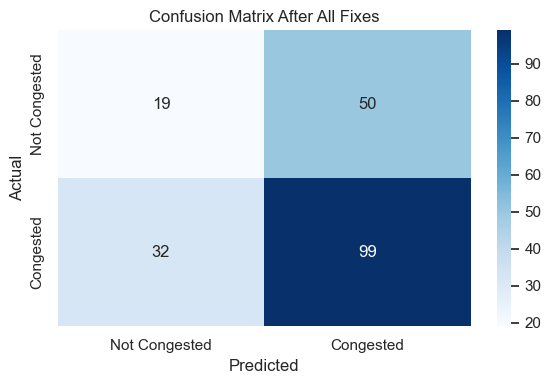


🔢 Classification Performance Metrics:
   Metric  Value
 Accuracy  0.590
Precision  0.664
   Recall  0.756
 F1 Score  0.707


In [17]:
#ALL FIX  APPLIED

# Step 1: Simulate data
np.random.seed(42)
sample_data = pd.DataFrame({
    'station_key': np.random.randint(10000, 99999, 1000),
    'traffic_direction_seq': np.random.randint(0, 2, 1000).astype(np.int8),
    'cardinal_direction_seq': np.random.randint(0, 8, 1000).astype(np.int8),
    'classification_seq': np.random.randint(0, 3, 1000).astype(np.int8),
    'year': np.random.choice([2019, 2020, 2021], 1000).astype(np.int16),
    'month': np.random.randint(1, 13, 1000).astype(np.int8),
    'day': np.random.randint(1, 29, 1000).astype(np.int8),
    'day_of_week': np.random.randint(0, 7, 1000).astype(np.int8),
    'public_holiday': np.random.choice([True, False], 1000),
    'school_holiday': np.random.choice([True, False], 1000),
    'daily_total': np.random.randint(0, 3000, 1000)
})
for i in range(24):
    sample_data[f'hour_{i:02d}'] = np.random.randint(0, 300, 1000).astype(np.int16)
sample_data['road_functional_hierarchy'] = np.random.choice(['Primary', 'Secondary', 'Local'], 1000)
sample_data['lane_count'] = np.random.randint(1, 5, 1000)
sample_data['road_classification_type'] = np.random.choice(['Freeway', 'Arterial', 'Collector'], 1000)
sample_data['suburb'] = np.random.choice(['SuburbA', 'SuburbB', 'SuburbC', 'SuburbD', 'SuburbE'], 1000)
sample_data['wgs84_latitude'] = np.random.uniform(-33.8, -33.7, 1000)
sample_data['wgs84_longitude'] = np.random.uniform(151.1, 151.3, 1000)

# Step 2: Target variable
sample_data['congested'] = (sample_data['daily_total'] > 1000).astype(int)

# Step 3: Fix 1 - Group noisy suburbs
suburb_counts = sample_data['suburb'].value_counts()
common_suburbs = suburb_counts[suburb_counts > 50].index
sample_data['suburb'] = sample_data['suburb'].apply(lambda x: x if x in common_suburbs else 'Other')

# Step 4: Fix 2 - Feature engineering
sample_data['morning_peak'] = sample_data[[f'hour_{i:02d}' for i in range(7, 10)]].sum(axis=1)
sample_data['evening_peak'] = sample_data[[f'hour_{i:02d}' for i in range(16, 19)]].sum(axis=1)

# Step 5: Feature prep
categorical_cols = ['suburb', 'road_functional_hierarchy', 'road_classification_type']
numerical_cols = [col for col in sample_data.columns if col not in categorical_cols + ['congested', 'daily_total']]
encoded_cats = pd.get_dummies(sample_data[categorical_cols], drop_first=True)
X_full = pd.concat([sample_data[numerical_cols], encoded_cats], axis=1)
y = sample_data['congested']

# Step 6: Fix 3 - Multicollinearity removal
cor_matrix = X_full.corr().abs()
upper = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X_full.drop(columns=to_drop, inplace=True)

# Step 7: Train-test split + SMOTE
X_train, X_test, y_train, y_test = train_test_split(X_full, y, stratify=y, test_size=0.2, random_state=42)
X_train_res, y_train_res = SMOTE(random_state=42).fit_resample(X_train, y_train)

# Step 8: Fix 4 - Hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}
grid = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5, scoring='f1', n_jobs=-1)
grid.fit(X_train_res, y_train_res)
best_model = grid.best_estimator_

# Step 9: Evaluation
y_pred = best_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

pd.set_option("display.max_columns", None)
pd.set_option("display.precision", 3)
report_df = pd.DataFrame(report).transpose()
report_df

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Not Congested', 'Congested'],
            yticklabels=['Not Congested', 'Congested'])
plt.title("Confusion Matrix After All Fixes")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


# Display performance metrics
def display_metrics(y_true, y_pred):
    data = {
        "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
        "Value": [
            accuracy_score(y_true, y_pred),
            precision_score(y_true, y_pred),
            recall_score(y_true, y_pred),
            f1_score(y_true, y_pred)
        ]
    }
    df = pd.DataFrame(data)
    print("\n🔢 Classification Performance Metrics:")
    print(df.to_string(index=False))

# Call the function
display_metrics(y_test, y_pred)
